In [1]:
import importlib
import argparse
import os, sys
import argparse
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

%matplotlib inline

In [20]:
from torch.autograd import Variable

In [3]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using Theano backend.


In [4]:
sys.path.insert(0, './../utils/')
from utils import *
from models import *

In [5]:
#Define parser
#name = 'bpi_2012'
name = 'bpi_2013'
#name = 'Road_Traffic_Fine_Management_Process'  

parser = {
    'train': True,
    'test': True,
    'model_class': 'AE',
    'model_name': '',
    'data_dir': '../data/',
    'data_file': name + '.csv',
    'anomaly_pct': 0.1,
    'input_dir': '../input/{}/'.format(name), 
    'output_dir': './output/{}/'.format(name),
    'batch_size' : 16,
    'epochs' : 10,
    'no_cuda' : False,
    'seed' : 7,
    'layer1': 1000,
    'layer2': 100,
    'lr': 0.002,
    'betas': (0.9, 0.999),   
    'lr_decay': 0.90,
}

args = argparse.Namespace(**parser)

In [6]:
if not os.path.isdir(args.output_dir):
    os.makedirs(args.output_dir)

In [7]:
preprocessed_data_name = os.path.join(args.input_dir, 'preprocessed_data_{}.pkl'.format(args.anomaly_pct))
with open(preprocessed_data_name, 'rb') as f:
    input_train = pickle.load(f)
    input_val = pickle.load(f)
    input_test = pickle.load(f)
    pad_index_train = pickle.load(f)
    pad_index_val = pickle.load(f)
    pad_index_test = pickle.load(f)
    activity_label_val = pickle.load(f)
    activity_label_test = pickle.load(f)
    time_label_val = pickle.load(f)
    time_label_test = pickle.load(f)
    train_case_num = pickle.load(f)
    val_case_num = pickle.load(f)
    test_case_num = pickle.load(f)
    train_row_num = pickle.load(f)
    val_row_num = pickle.load(f)
    test_row_num = pickle.load(f)
    min_value = pickle.load(f)
    max_value = pickle.load(f)
    cols = pickle.load(f)

In [9]:
input_train.shape

(892, 35, 8)

# Define model

In [10]:
def create_lstm_autoencoder(timesteps, input_dim, latent_dim):
    """
    Creates an LSTM Autoencoder (VAE). Returns Autoencoder, Encoder, Generator. 
    (All code by fchollet - see reference.)
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        latent_dim: int, latent z-layer shape. 
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
    """

    inputs = Input(shape=(timesteps, input_dim,))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)
    
    output = Dense(, kernel_initializer="glorot_uniform", name="act_output", activation="softmax")(b2_1)
    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [13]:
if args.train:
    lstm_ae = create_lstm_autoencoder(timesteps=input_train.shape[1], 
                                      input_dim=input_train.shape[2],
                                      latent_dim=args.layer2)
    lstm_ae.fit(input_train,input_train, epochs=20, batch_size=16)

Epoch 1/20
892/892 [==============================] - 1s - loss: 0.1485      

# Predict

In [14]:
if args.test:
    preds = lstm_ae.predict(input_test)

In [21]:
input_test = Variable(torch.Tensor(input_test).float())
recon_test = Variable(torch.Tensor(preds).float())

# Evaluate

In [22]:
predicted_time, predicted_activity, true_time, true_activity = getError(recon_test, input_test, pad_index_test)

In [24]:
def plotConfusionMaxtrix(error_df, threshold, variable='Activity'):
    LABELS = ['Normal', 'Anomaly']
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable == 'Activity':
        matrix = confusion_matrix(error_df.ActivityLabel, y_pred)
    else:
        matrix = confusion_matrix(error_df.TimeLabel, y_pred)
        
    plt.figure(figsize=(7, 7))
    sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title('Confusion matrix of {}'.format(variable))
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [25]:
def eval(error_df, threshold, variable='Activity'):
    y_pred = [1 if e > threshold else 0 for e in error_df.Error.values]
    
    if variable=='Activity':
        y_true = error_df.ActivityLabel
    else:
        y_true = error_df.TimeLabel
    
    score = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        
    print('Evaluation of {}'.format(variable))
    print('Precision: {:.2f}'.format(score[0]))
    print('Recall: {:.2f}'.format(score[1]))
    print('Fscore: {:.2f}'.format(score[2]))
    #print('Support: {:.2f}'.format(score[3]))

## Time

In [27]:
error = np.abs(true_time - predicted_time)
error_time_df = pd.DataFrame({'Error': error,
                              'TimeLabel': time_label_test})

In [29]:
error_time_df.head()

,Error,TimeLabel
5589,0.007704,1
5590,0.005304,0
5591,0.007905,0
5592,0.011222,0
5593,0.007307,0


In [28]:
time_threshold = np.mean(error_time_df['Error'])
print('Threshold of Time: {}'.format(time_threshold))

Threshold of Time: 0.010692259548904121


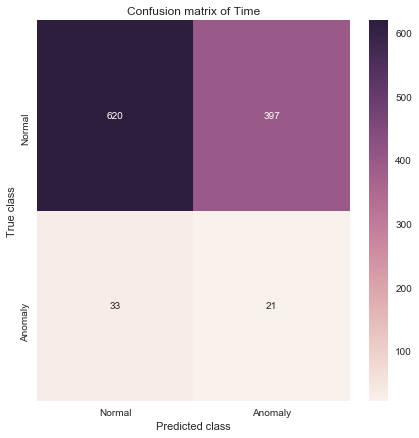

In [30]:
plotConfusionMaxtrix(error_time_df, time_threshold, variable='Time')

In [31]:
eval(error_time_df, time_threshold, variable='Time')

Evaluation of Time
Precision: 0.90
Recall: 0.60
Fscore: 0.71


## Activity

In [32]:
error = np.mean(np.power(true_activity - predicted_activity, 2), axis = 1)
error_activity_df = pd.DataFrame({'Error': error,
                                  'ActivityLabel': activity_label_test})

In [33]:
error_activity_df.head()

,ActivityLabel,Error
5589,0,0.108973
5590,0,0.129486
5591,0,0.108942
5592,0,0.129520
5593,0,0.109034


In [34]:
activity_threshold = np.mean(error_activity_df['Error'])
print('Threshold of Activity: {}'.format(activity_threshold))

Threshold of Activity: 0.1182347612262436


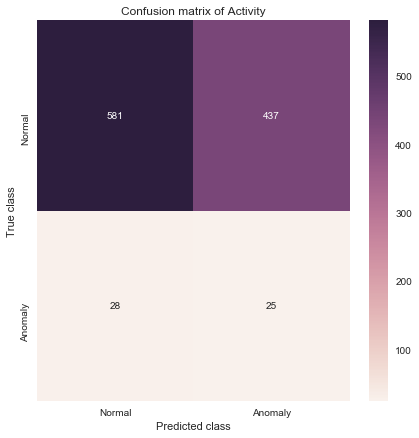

In [35]:
plotConfusionMaxtrix(error_activity_df, activity_threshold, variable='Activity')

In [37]:
eval(error_activity_df, activity_threshold, variable='Activity')

Evaluation of Activity
Precision: 0.91
Recall: 0.57
Fscore: 0.68
